## Is it a bird?

지금부터 새를 분류하는 딥러닝 모델을 만드는 실습을 진행할 것이다. 이 강의의 실습에서는 주로 fastai 라이브러리가 많이 사용되는데, 이는 fast.ai에서 개발한 라이브러리로, 많은 딥러닝 작업들을 빠르게 진행할 수 있게 도와주는 많은 명령어들이 포함되어 있다.

In [1]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
beatrix-jupyterlab 3.1.6 requires google-cloud-bigquery-storage, which is not installed.
tensorflow 2.6.2 requires numpy~=1.19.2, but you have numpy 1.20.3 which is incompatible.
tensorflow 2.6.2 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.6.2 requires typing-extensions~=3.7.4, but you have typing-extensions 3.10.0.2 which is incompatible.
tensorflow 2.6.2 requires wrapt~=1.12.1, but you have wrapt 1.13.3 which is incompatible.
tensorflow-transform 1.5.0 requires absl-py<0.13,>=0.9, but you have absl-py 0.15.0 which is incompatible.
tensorflow-tran

2015년도에 새를 분류하는 컴퓨터 시스템을 제작하는 것은 매우 어려운 task로 여겨졌다. 다음의 xkcd joke를 보면 왜 그러했는지 이해할 수 있다.
[this XKCD joke](https://xkcd.com/1425/):

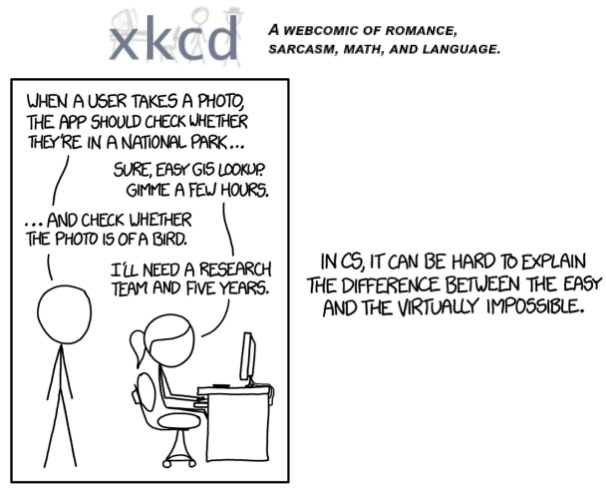

하지만, 현대에 들어서는 이 작업을 몇 분이면 해결할 수 있다!! 바로 다음의 과정을 통해서 말이다.

1. DuckDuckGo를 사용하여 '새 사진'을 검색
1. DuckDuckGo를 사용하여 '숲 사진'을 검색
1. 사전 학습된 신경망을 이 두 그룹의 이미지를 알아볼 수 있도록 Fine-tuning
1. 이 모델을 '새 사진'에 대해서 돌려서, 이 모델이 잘 작동하는지 확인

## Step 1: Download images of birds and non-birds

In [3]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [4]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('bird photos', max_images=1)
urls[0]

Searching for 'bird photos'


'https://jooinn.com/images/beautiful-bird-3.jpg'

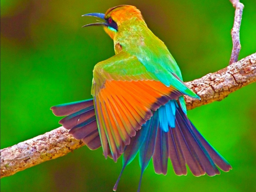

In [5]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

'새 사진'에 대해 했던 작업을 '숲 사진'에도 똑같이 적용한다.

Searching for 'forest photos'


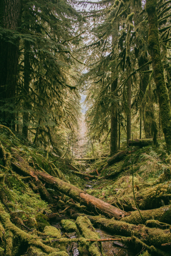

In [6]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

In [7]:
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'


## Step 2: Train model

어떤 사진들은 올바르게 다운로드되지 않았을 수도 있으니, 올바르게 다운로드되지 않은 사진들은 모두 삭제하였다.

In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

모델을 학습시키기 위해서, 'DataLoader'가 필요하다. 이 'DataLoader'는 training set과 validation set을 포함하고 있다. 각각은 모델을 생성하기 위해, 모델의 정확도를 측정하기 위해 사용된다. fastai의 'DataBlock'을 사용하여, 손쉽게 생성할 수 있다.

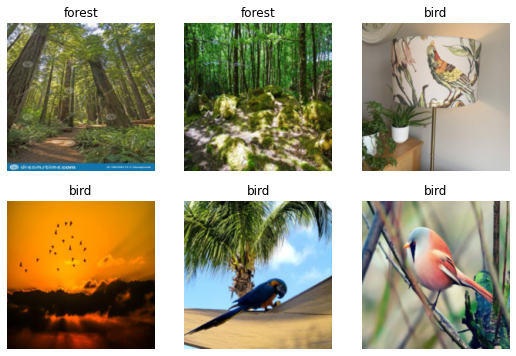

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

이제 모델을 학습시키기 위한 모든 준비가 끝났다. 가장 빠르면서도 널리 사용되는 CV model인 'resnet18'을 사용하였다. 이 모델은 CPU에서도, 몇 분이면 학습된다!! (GPU에서라면, 몇 초도 가능!!)

fastai는 'fine_tune()'이라는 method를 통해 손쉽게 사전 학습된 모델을 fine-tuning 할 수 있다.

In [10]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.853280,0.545075,0.235294,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.333276,0.049398,0.029412,00:01
1,0.201302,0.009484,0.000000,00:01
2,0.131600,0.013576,0.000000,00:01


이렇게 학습된 모델을 평가 셋에서 돌렸더니, 100%의 성능을 보여줬다.

'Fine-tuning'은 다른 데이터셋에서 학습된 다른 모델에서부터 시작해서, 자기만의 특정 데이터셋에 알맞게 가중치를 미세하게 조정해 나가는 과정을 말한다. 이러한 방식은 현재 딥러닝의 많은 분야에서 사용되는 방식이다.

## Step 3: Use Model

In [11]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 0.9998


이와 같이 딥러닝을 사용하면 불과 몇 초도 안 걸려서 '새' 사진을 분류해낼 수 있다. 딥러닝을 사용하면 이렇게 쉬운 일을 왜 이전에는 하지 못했을까? 아, 당연히 딥러닝을 사용하지 않았기 때문인 것은 맞지만, 그러면 질문을 바꿔서 왜 이전의 머신러닝은 불가능했을까? 그 답은 두 방법의 작동 방식에서 찾을 수 있다. 머신러닝은 분류를 위해 이미지에서 어떠한 특징을 찾아내야 하는지를 사람이 다 가르쳐줘야 한다. 하지만, 딥러닝은 그렇지 않고, 자기 스스로 이미지에서 어떤 특징을 찾아내야 하는지 스스로 학습한다. 이러한 차이점으로 인해 2015년 이전에는 '새' 사진을 분류하기 위해 수많은 시간을 쏟았어야 하는 것이다.